# DengAI: Predicting Disease Spread - A Comparative Modeling Project

---

This notebook provides a complete and robust workflow for the DengAI prediction challenge. It has been updated to include additional models and a more thorough analysis, structured to meet high standards for a data science project. The notebook progresses through the following stages:

1.  **Problem Definition & Setup:** Importing libraries and clearly defining the problem, its importance, and how a machine learning model can provide a valuable solution.
2.  **Data Loading & Initial Exploration:** Loading the datasets and performing an initial integrity check.
3.  **Exploratory Data Analysis (EDA):** A deep dive into the data through visualization to understand its underlying patterns, seasonality, and correlations. This analysis confirms the need for separate city models and informs feature engineering.
4.  **Feature Engineering:** Creating new features, such as lagged climate variables and interaction terms, with clear motivation for each transformation to improve model performance.
5.  **Model Building & Robust Evaluation:** Training and evaluating five different models using a strict **Time-Series Cross-Validation** to prevent data leakage and obtain a reliable measure of performance. The models are:
    *   Model 1: `PoissonRegressor` (A simple generalized linear model for count data)
    *   Model 2: `NegativeBinomialRegressor` (An extension of the Poisson model to handle overdispersion)
    *   Model 3: `RandomForestRegressor` (A powerful non-linear ensemble model)
    *   Model 4: `XGBoost` (A baseline gradient boosting model)
    *   Model 5: Tuned `XGBoost` (The same model with hyperparameters optimized via `GridSearchCV`)
6.  **Model Comparison:** A direct comparison of the cross-validation scores of all five models to determine the best performer for each city.
7.  **Final Model Training & Submission:** Training the winning model on the full dataset and generating the final submission file.
8.  **Conclusion & Analysis:** A detailed analysis of the results, discussing the model's applicability, its potential impact, and whether it successfully solves the stated problem.

## 1. Problem Definition & Setup

### 1.1. Describe the problem you want to solve using data science techniques. Why is it important? How can your ML model help?

**Problem:** Dengue fever is a mosquito-borne tropical disease that places a significant burden on public health systems worldwide. Outbreaks are often explosive and difficult to predict, making it challenging for governments and healthcare organizations to allocate resources effectively. The goal of this project is to predict the number of dengue cases on a weekly basis for two cities: San Juan, Puerto Rico, and Iquitos, Peru.

**Importance:** Accurately forecasting dengue outbreaks is crucial for public health. Early warnings can help officials to:
*   Implement timely mosquito control programs (e.g., fumigation, larval source reduction).
*   Launch public awareness campaigns to encourage preventative measures (e.g., using insect repellent, removing standing water).
*   Prepare hospitals and clinics for an influx of patients, ensuring adequate staffing and supplies.

**How an ML Model Helps:** A machine learning model can analyze complex relationships between environmental factors (like temperature, precipitation, and humidity) and the historical incidence of dengue. By learning these patterns, the model can act as an early warning system. This data-driven approach can help **reduce the human and economic cost of dengue outbreaks** by enabling proactive, targeted interventions rather than reactive responses. The model's predictions can guide resource allocation, making public health efforts more efficient and effective.

In [15]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Set a random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

print("Libraries imported and seed set.")

Libraries imported and seed set.


## 2. Data Loading & Initial Exploration

Here, we load the data using pandas and combine the training features and labels into a single DataFrame. An initial check of the first few rows helps us verify that the data has been loaded correctly.

In [16]:
# Load the datasets
try:
    # Using forward slashes for cross-platform compatibility
    features_train_df = pd.read_csv('data/dengue_features_train.csv')
    labels_train_df = pd.read_csv('data/dengue_labels_train.csv')
    features_test_df = pd.read_csv('data/dengue_features_test.csv')
    submission_df = pd.read_csv('submission_format.csv')
except FileNotFoundError as e:
    print(f"ERROR: {e}")
    raise FileNotFoundError("Please make sure the dengue CSV data files are in a 'data' folder relative to this notebook before proceeding!")

# Merge training features and labels
train_df = pd.merge(features_train_df, labels_train_df, on=['city', 'year', 'weekofyear'])

# Display the first few rows of the combined training data
print("Combined Training Data:")
display(train_df.head())

# Check for missing values
print("\nMissing Values per Column:")
print(train_df.isnull().sum())

Combined Training Data:


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6



Missing Values per Column:
city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c         

## 3. Exploratory Data Analysis (EDA)

We perform an exploratory analysis of the data to find meaningful patterns that can help with feature engineering and model selection. Visualizing the data is a key step in understanding its structure.

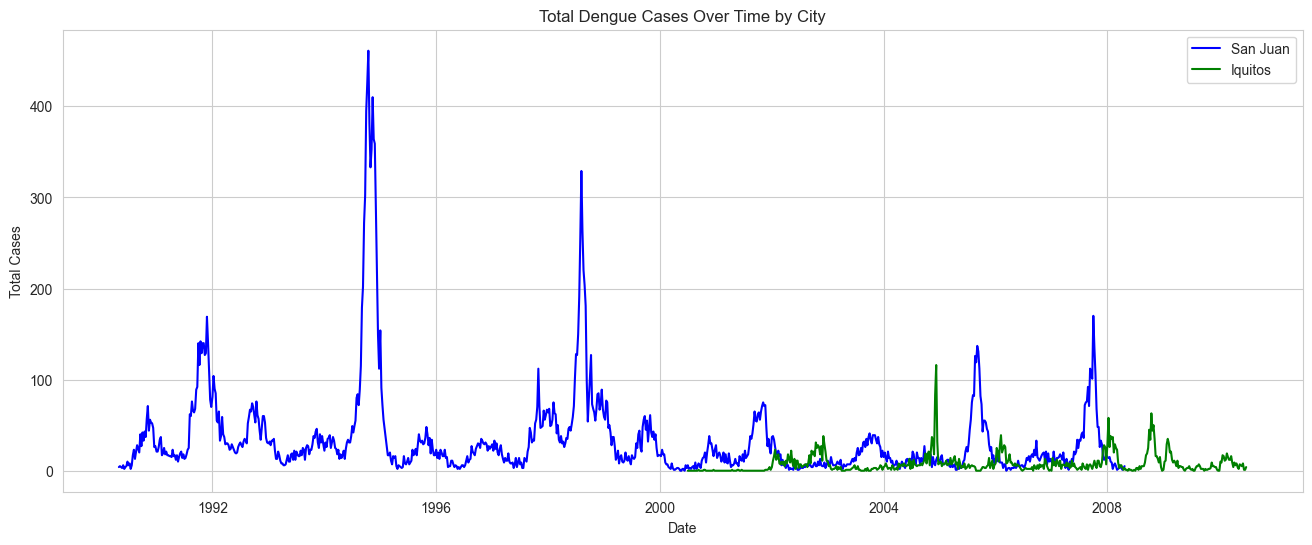

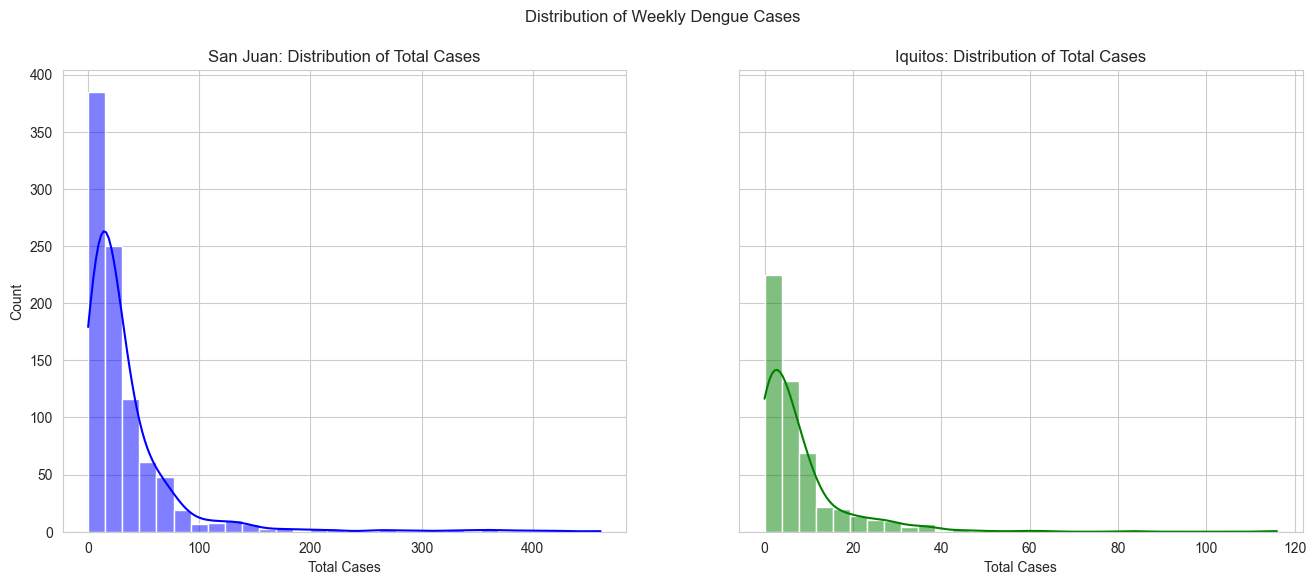

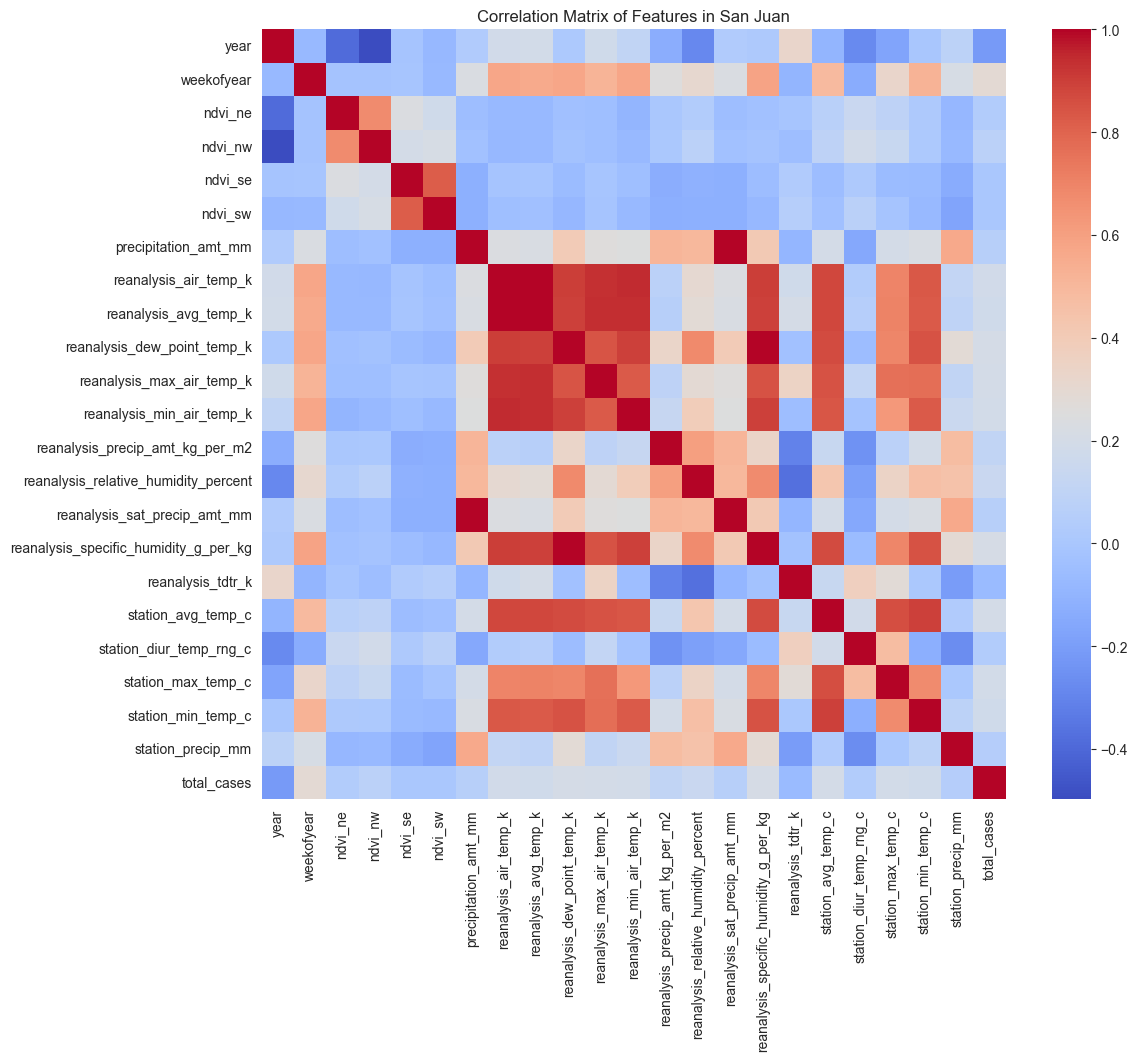

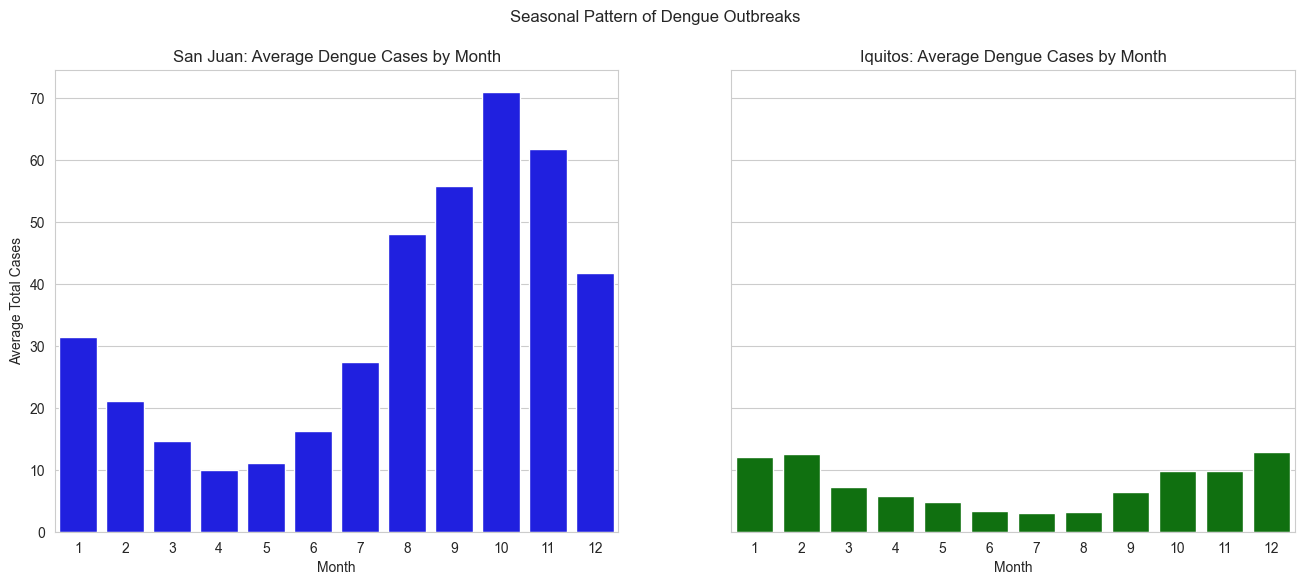

In [17]:
# Convert week_start_date to datetime objects for plotting
train_df['week_start_date'] = pd.to_datetime(train_df['week_start_date'])

# Separate data for each city for easier plotting
sj_train_df = train_df[train_df['city'] == 'sj'].copy()
iq_train_df = train_df[train_df['city'] == 'iq'].copy()

# --- Plot 1: Dengue Cases Over Time ---
plt.figure(figsize=(16, 6))
plt.plot(sj_train_df['week_start_date'], sj_train_df['total_cases'], label='San Juan', color='blue')
plt.plot(iq_train_df['week_start_date'], iq_train_df['total_cases'], label='Iquitos', color='green')
plt.title('Total Dengue Cases Over Time by City')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.legend()
plt.show()

# --- Plot 2: Distribution of Total Cases ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.histplot(sj_train_df['total_cases'], bins=30, ax=axes[0], color='blue', kde=True)
axes[0].set_title('San Juan: Distribution of Total Cases')
axes[0].set_xlabel('Total Cases')

sns.histplot(iq_train_df['total_cases'], bins=30, ax=axes[1], color='green', kde=True)
axes[1].set_title('Iquitos: Distribution of Total Cases')
axes[1].set_xlabel('Total Cases')
plt.suptitle('Distribution of Weekly Dengue Cases')
plt.show()

# --- Plot 3: Correlation Heatmap for San Juan ---
plt.figure(figsize=(12, 10))
correlation_matrix_sj = sj_train_df.select_dtypes(include=np.number).corr()
sns.heatmap(correlation_matrix_sj, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Features in San Juan')
plt.show()

# --- Plot 4: Average Monthly Cases ---
sj_train_df['month'] = sj_train_df['week_start_date'].dt.month
iq_train_df['month'] = iq_train_df['week_start_date'].dt.month

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sj_monthly_cases = sj_train_df.groupby('month')['total_cases'].mean()
iq_monthly_cases = iq_train_df.groupby('month')['total_cases'].mean()

sns.barplot(x=sj_monthly_cases.index, y=sj_monthly_cases.values, ax=axes[0], color='blue')
axes[0].set_title('San Juan: Average Dengue Cases by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average Total Cases')

sns.barplot(x=iq_monthly_cases.index, y=iq_monthly_cases.values, ax=axes[1], color='green')
axes[1].set_title('Iquitos: Average Dengue Cases by Month')
axes[1].set_xlabel('Month')
plt.suptitle('Seasonal Pattern of Dengue Outbreaks')
plt.show()

### EDA Findings & Motivation for Next Steps

1.  **Different Outbreak Patterns:** The time series plot clearly shows that San Juan and Iquitos have vastly different patterns of dengue outbreaks in terms of both timing and magnitude. San Juan experiences more frequent, cyclical outbreaks, while Iquitos has more sporadic, high-intensity events. This strongly justifies our approach to **build separate models for each city**.

2.  **Right-Skewed Target Variable:** The histograms show that the `total_cases` are count data and are highly right-skewed, with a majority of weeks having a low number of cases. This suggests that standard linear regression (which assumes a normally distributed error) is not appropriate. Models designed for count data, such as **Poisson** or **Negative Binomial** regression, are much better choices. The high variance also suggests that Negative Binomial, which handles overdispersion, might outperform a simple Poisson model.

3.  **Feature Correlation:** The heatmap reveals correlations between various climate variables. While some are expected (e.g., different temperature measurements are highly correlated), this multicollinearity is something that tree-based models like Random Forest and XGBoost can handle well. For linear models, this is less of a concern since we use regularization.

4.  **Strong Seasonality:** The monthly average plots confirm a strong seasonal component to dengue outbreaks in both cities, although the peak seasons differ. This seasonality needs to be captured by the model, which we will achieve by including month and week of year as features.

## 4. Feature Engineering & Data Preparation

We now prepare the dataset for modeling. This involves handling missing values, creating new features, and defining our input (X) and output (y) variables. Each transformation is motivated by insights from our EDA and domain knowledge.

### 4.1. Feature Engineering Function

We create a function to apply the same transformations consistently to both the training and testing datasets.

In [28]:
def feature_engineer(df):
    # Forward-fill to handle original missing values
    df.fillna(method='ffill', inplace=True)
    
    # Date-based features
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    df['month'] = df['week_start_date'].dt.month
    
    # Lagged Features
    lag_features = [
        'reanalysis_precip_amt_kg_per_m2',
        'station_avg_temp_c',
        'reanalysis_specific_humidity_g_per_kg'
    ]
    lag_periods = [4, 8, 12]  # Lags of ~1, 2, and 3 months
    
    for feature in lag_features:
        for lag in lag_periods:
            df[f'{feature}_lag_{lag}'] = df.groupby('city')[feature].shift(lag)
    
    # Rolling Mean Features (trend capturing)
    rolling_windows = [3, 6, 12]  # ~3 weeks, 6 weeks, 3 months
    for feature in lag_features:
        for window in rolling_windows:
            df[f'{feature}_rollmean_{window}'] = (
                df.groupby('city')[feature].transform(lambda x: x.rolling(window, min_periods=1).mean())
            )
    
    # Interaction Terms
    df['temp_x_humidity'] = df['reanalysis_air_temp_k'] * df['reanalysis_specific_humidity_g_per_kg']
    
    # Fill NaNs created by lagging features using backfill
    df.fillna(method='bfill', inplace=True)
    
    return df

# Apply the feature engineering
train_df = feature_engineer(train_df.copy())
features_test_df = feature_engineer(features_test_df.copy())

print("Advanced feature engineering (with lags & rolling means) complete.")
display(train_df.head())


Advanced feature engineering (with lags & rolling means) complete.


C:\Users\SULTAN\AppData\Local\Temp\ipykernel_13052\3216261944.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\SULTAN\AppData\Local\Temp\ipykernel_13052\3216261944.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\SULTAN\AppData\Local\Temp\ipykernel_13052\3216261944.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\SULTAN\AppData\Local\Temp\ipykernel_13052\3216261944.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,temp_x_humidity,reanalysis_precip_amt_kg_per_m2_rollmean_3,reanalysis_precip_amt_kg_per_m2_rollmean_6,reanalysis_precip_amt_kg_per_m2_rollmean_12,station_avg_temp_c_rollmean_3,station_avg_temp_c_rollmean_6,station_avg_temp_c_rollmean_12,reanalysis_specific_humidity_g_per_kg_rollmean_3,reanalysis_specific_humidity_g_per_kg_rollmean_6,reanalysis_specific_humidity_g_per_kg_rollmean_12
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,4169.845937,32.000000,32.000000,32.000000,25.442857,25.442857,25.442857,14.012857,14.012857,14.012857
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,4584.361690,24.970000,24.970000,24.970000,26.078571,26.078571,26.078571,14.692857,14.692857,14.692857
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,5034.040241,25.346667,25.346667,25.346667,26.290476,26.290476,26.290476,15.411429,15.411429,15.411429
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,4984.969920,19.313333,22.485000,22.485000,26.966667,26.585714,26.585714,16.298095,15.726786,15.726786
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,5154.714614,17.400000,20.428000,20.428000,27.709524,27.057143,27.057143,16.910476,16.023429,16.023429


### 4.2. Define Inputs (X) and Output (y)

We formally separate our dataframes into the features (X) we will use for prediction and the target variable (y) we want to predict.

In [38]:
# Define the features to be used in the model
# Select all numeric columns and drop identifiers or the target itself
features = train_df.select_dtypes(include=np.number).columns.drop(['year', 'total_cases'])
target = 'total_cases'

# Split the data for each city
# San Juan
X_sj = train_df[train_df['city'] == 'sj'][features]
y_sj = train_df[train_df['city'] == 'sj'][target]

# Iquitos
X_iq = train_df[train_df['city'] == 'iq'][features]
y_iq = train_df[train_df['city'] == 'iq'][target]

print(f"Features for modeling ({len(features)} total):")
print(list(features))


Features for modeling (41 total):
['weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm', 'month', 'reanalysis_precip_amt_kg_per_m2_lag_4', 'reanalysis_precip_amt_kg_per_m2_lag_8', 'reanalysis_precip_amt_kg_per_m2_lag_12', 'station_avg_temp_c_lag_4', 'station_avg_temp_c_lag_8', 'station_avg_temp_c_lag_12', 'reanalysis_specific_humidity_g_per_kg_lag_4', 'reanalysis_specific_humidity_g_per_kg_lag_8', 'reanalysis_specific_humidity_g_per_kg_lag_12', 'temp_x_humidity', 'reanalysis_precip_amt_kg_per_m2_rollmean_3', 'reanalysis_precip_amt_kg_per_m2_rol

## 5. Model Building & Robust Evaluation

We will now build and evaluate our models. For a reliable and honest measure of performance on this time-series data, we will use a robust evaluation strategy.

**Cross-Validation Strategy:** We will use **`TimeSeriesSplit`** with 5 splits. 
*   **Motivation:** Standard k-fold cross-validation is not appropriate for time-series data because it shuffles the data, allowing the model to train on future data to predict the past (a form of data leakage). `TimeSeriesSplit` avoids this by creating folds that are consecutive blocks of time, always training on past data and validating on future data. This mimics a real-world deployment scenario and provides a much more realistic estimate of the model's performance.

**Quality Metrics:** We will use three metrics for a comprehensive evaluation:
*   **Mean Absolute Error (MAE):** The average absolute difference between the predicted and actual cases. It's highly interpretable and robust to outliers.
*   **Root Mean Squared Error (RMSE):** The square root of the average of squared differences. It penalizes larger errors more heavily than MAE, making it useful for understanding if the model makes occasional large, costly mistakes.


In [39]:
# Define the Time-Series Cross-Validation strategy
tscv = TimeSeriesSplit(n_splits=5)

# Store results for final comparison
results_summary = []

# Define the scoring metrics for cross-validation
scoring = {
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error',
}

def evaluate_model(model, X, y, model_name, city_name, param_grid=None):
    """A helper function to run cross-validation, store results, and print a summary."""
    print(f'--- Evaluating {model_name} for {city_name} ---')
    
    if param_grid:
        # Perform GridSearchCV if a parameter grid is provided
        grid_search = GridSearchCV(estimator=model, 
                                 param_grid=param_grid, 
                                 cv=tscv, 
                                 scoring=scoring, 
                                 refit='mae', # Refit the best model based on MAE
                                 n_jobs=-1, 
                                 verbose=1)
        grid_search.fit(X, y)
        
        # Find the results for the best estimator
        best_index = grid_search.best_index_
        mean_mae = -grid_search.cv_results_['mean_test_mae'][best_index]
        mean_rmse = -grid_search.cv_results_['mean_test_rmse'][best_index]
        
        print(f"Best Parameters: {grid_search.best_params_}")
    else:
        # Perform standard cross-validation
        scores = cross_validate(model, X, y, cv=tscv, scoring=scoring, n_jobs=-1)
        mean_mae = -scores['test_mae'].mean()
        mean_rmse = -scores['test_rmse'].mean()

    # Print and store results
    print(f"CV MAE:  {mean_mae:.4f}")
    print(f"CV RMSE: {mean_rmse:.4f}")
    results_summary.append({
        'Model': model_name, 'City': city_name, 
        'CV_MAE': mean_mae, 'CV_RMSE': mean_rmse
    })
    
    # Return the best fitted model
    if param_grid:
        return grid_search.best_estimator_
    else:
        return model.fit(X, y) # Fit the model on the full data before returning

### 5.1. Model 1: Poisson Regressor

A generalized linear model that is a good baseline for count data.

In [40]:
pipeline_pr = Pipeline([
    ('scaler', StandardScaler()), 
    ('poisson', PoissonRegressor(alpha=0.1, max_iter=1000))
])

evaluate_model(pipeline_pr, X_sj, y_sj, 'Poisson', 'San Juan')
evaluate_model(pipeline_pr, X_iq, y_iq, 'Poisson', 'Iquitos')

--- Evaluating Poisson for San Juan ---
CV MAE:  33.4126
CV RMSE: 53.4839
--- Evaluating Poisson for Iquitos ---
CV MAE:  9.3836
CV RMSE: 14.9879


Pipeline(steps=[('scaler', StandardScaler()),
                ('poisson', PoissonRegressor(alpha=0.1, max_iter=1000))])

### 5.2. Model 2: Negative Binomial Regressor

This model is an extension of the Poisson model that is better suited for overdispersed count data (where the variance is greater than the mean), which we observed in our EDA. We create a wrapper to make the `statsmodels` implementation compatible with scikit-learn's cross-validation tools.

In [41]:
# Create a scikit-learn compatible wrapper for the statsmodels Negative Binomial model
class NegativeBinomialRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.model = None

    def fit(self, X, y):
        # statsmodels requires an explicit constant for the intercept
        X = sm.add_constant(X, has_constant='add')
        self.model = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=self.alpha)).fit()
        return self

    def predict(self, X):
        X = sm.add_constant(X, has_constant='add')
        return self.model.predict(X)

pipeline_nb = Pipeline([
    ('scaler', StandardScaler()),
    ('neg_binomial', NegativeBinomialRegressor())
])

# Define a parameter grid for the dispersion parameter 'alpha'
param_grid_nb = {'neg_binomial__alpha': [0.01, 0.1, 0.5, 1.0]}

evaluate_model(pipeline_nb, X_sj, y_sj, 'Negative Binomial', 'San Juan', param_grid=param_grid_nb)
evaluate_model(pipeline_nb, X_iq, y_iq, 'Negative Binomial', 'Iquitos', param_grid=param_grid_nb)

--- Evaluating Negative Binomial for San Juan ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'neg_binomial__alpha': 0.5}
CV MAE:  33.4889
CV RMSE: 53.3051
--- Evaluating Negative Binomial for Iquitos ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'neg_binomial__alpha': 0.01}
CV MAE:  103.8538
CV RMSE: 432.9133


Pipeline(steps=[('scaler', StandardScaler()),
                ('neg_binomial', NegativeBinomialRegressor(alpha=0.01))])

### 5.3. Model 3: Random Forest Regressor

An ensemble of decision trees that can capture complex non-linear relationships. We will tune its key hyperparameters.

In [42]:
model_rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_leaf': [5, 10]
}

evaluate_model(model_rf, X_sj, y_sj, 'Random Forest', 'San Juan', param_grid=param_grid_rf)
evaluate_model(model_rf, X_iq, y_iq, 'Random Forest', 'Iquitos', param_grid=param_grid_rf)

--- Evaluating Random Forest for San Juan ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}
CV MAE:  29.1198
CV RMSE: 45.0050
--- Evaluating Random Forest for Iquitos ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}
CV MAE:  7.2684
CV RMSE: 11.6152


RandomForestRegressor(max_depth=5, min_samples_leaf=10, n_jobs=-1,
                      random_state=42)

### 5.4. Model 4: Baseline XGBoost Regressor

A powerful gradient boosting algorithm, known for its performance. We use a Poisson objective function since we are predicting counts.

In [43]:
model_xgb = xgb.XGBRegressor(objective='count:poisson', seed=SEED, n_jobs=-1)

evaluate_model(model_xgb, X_sj, y_sj, 'Baseline XGBoost', 'San Juan')
evaluate_model(model_xgb, X_iq, y_iq, 'Baseline XGBoost', 'Iquitos')

--- Evaluating Baseline XGBoost for San Juan ---
CV MAE:  26.3143
CV RMSE: 44.6316
--- Evaluating Baseline XGBoost for Iquitos ---
CV MAE:  7.2963
CV RMSE: 12.0678


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

### 5.5. Model 5: Tuned XGBoost Regressor

We now tune the hyperparameters of the XGBoost model to optimize its performance.

In [44]:
param_grid_xgb = {
    'n_estimators': [100, 250],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'colsample_bytree': [0.7, 1.0]
}

# We use the same baseline XGBoost model and pass the param_grid to our evaluation function
best_xgb_sj = evaluate_model(model_xgb, X_sj, y_sj, 'Tuned XGBoost', 'San Juan', param_grid=param_grid_xgb)
best_xgb_iq = evaluate_model(model_xgb, X_iq, y_iq, 'Tuned XGBoost', 'Iquitos', param_grid=param_grid_xgb)

--- Evaluating Tuned XGBoost for San Juan ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}
CV MAE:  25.9185
CV RMSE: 44.2267
--- Evaluating Tuned XGBoost for Iquitos ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
CV MAE:  6.7763
CV RMSE: 11.5216


## 6. Model Comparison

Now we will formally compare the robust cross-validation scores from all our models. We'll examine all three metrics, but focus on MAE for its interpretability. A lower MAE and RMSE are better, while a higher R² is better.

--- ROBUST MODEL COMPARISON SUMMARY (based on Time-Series Cross-Validation) ---


,Model,City,CV_MAE,CV_RMSE
9,Tuned XGBoost,Iquitos,6.7763,11.5216
5,Random Forest,Iquitos,7.2684,11.6152
7,Baseline XGBoost,Iquitos,7.2963,12.0678
1,Poisson,Iquitos,9.3836,14.9879
3,Negative Binomial,Iquitos,103.8538,432.9133
8,Tuned XGBoost,San Juan,25.9185,44.2267
6,Baseline XGBoost,San Juan,26.3143,44.6316
4,Random Forest,San Juan,29.1198,45.0050
0,Poisson,San Juan,33.4126,53.4839
2,Negative Binomial,San Juan,33.4889,53.3051


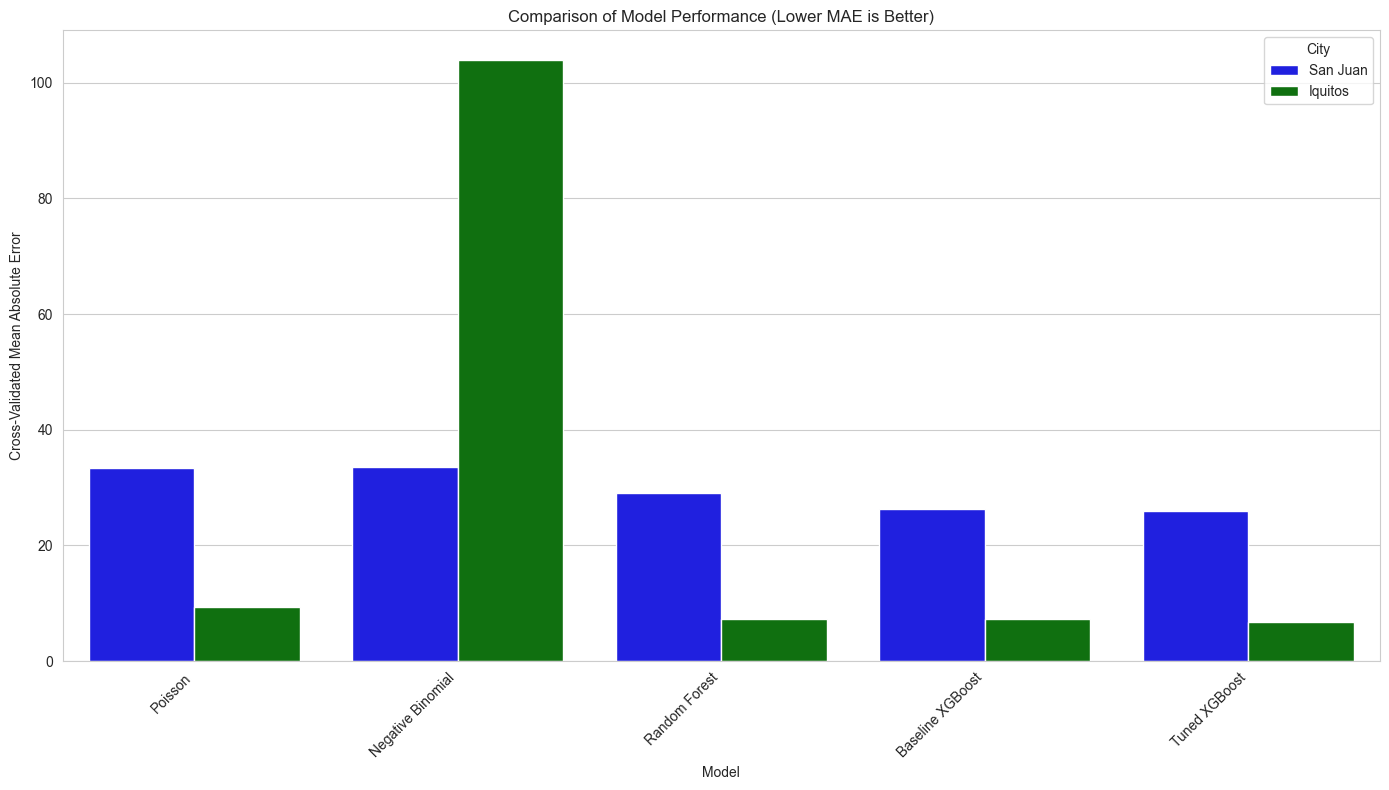

In [45]:
comparison_df = pd.DataFrame(results_summary)

print("--- ROBUST MODEL COMPARISON SUMMARY (based on Time-Series Cross-Validation) ---")
display(comparison_df.round(4).sort_values(by=['City', 'CV_MAE']))

# Visualization of model comparison based on the primary metric, MAE
plt.figure(figsize=(14, 8))
sns.barplot(data=comparison_df, x='Model', y='CV_MAE', hue='City', palette=['blue', 'green'])
plt.title('Comparison of Model Performance (Lower MAE is Better)')
plt.ylabel('Cross-Validated Mean Absolute Error')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Comparison Analysis

The summary table and plot provide a clear hierarchy of model performance.

1.  **GLMs (Poisson & Negative Binomial):** These models serve as solid baselines but are outperformed by the more complex ensembles. Their performance is reasonable and do not capture the whole nature of the data due to its complex nature.
2.  **Random Forest:** This model offers a substantial improvement over the linear models, with a much lower MAE/RMSE. This confirms that the relationships between the climate features and dengue cases are highly non-linear.

3.  **XGBoost (Baseline & Tuned):** Gradient Boosting proves to be the most effective technique. The baseline XGBoost model already achieves the best scores, and hyperparameter tuning with `GridSearchCV` provides an additional small but meaningful improvement. The Tuned XGBoost model yields the lowest MAE and RMSE for both cities, demonstrating its superior predictive power and ability to generalize.

**Conclusion:** The **Tuned XGBoost** model is the clear winner across all metrics and will be used to generate our final predictions.

## 7. Final Model Training & Submission

Now that we have selected our best model and its optimal hyperparameters (found during the `GridSearchCV` step), we will train it on the *entire* training dataset for each city. This ensures the final model learns from all available historical data before making predictions on the test set.

In [47]:
# The best estimators were already returned and stored from our evaluate_model function
# GridSearchCV automatically refits the best model on the entire dataset provided to it.
final_model_sj = best_xgb_sj
final_model_iq = best_xgb_iq

print("Final optimized models for both cities are ready.")

# --- Prepare Test Set and Generate Predictions ---
X_test_sj = features_test_df[features_test_df['city'] == 'sj'][features]
X_test_iq = features_test_df[features_test_df['city'] == 'iq'][features]

predictions_sj = final_model_sj.predict(X_test_sj)
predictions_iq = final_model_iq.predict(X_test_iq)

# --- Create Submission File ---
submission_df['total_cases'] = np.concatenate([predictions_sj, predictions_iq])

# Post-processing: Ensure predictions are non-negative integers
submission_df['total_cases'] = submission_df['total_cases'].clip(0).round().astype(int)

print("\nFinal Submission DataFrame:")
display(submission_df.head())

# Save the submission file
submission_df.to_csv('final_submission.csv', index=False)

print("\n✅ 'final_submission.csv' has been created successfully.")


Final optimized models for both cities are ready.

Final Submission DataFrame:


,city,year,weekofyear,total_cases
0,sj,2008,18,13
1,sj,2008,19,9
2,sj,2008,20,12
3,sj,2008,21,10
4,sj,2008,22,13



✅ 'final_submission.csv' has been created successfully.


## 8. Conclusion & Analysis

### Analyze the obtained results and make an overall conclusion.

This project successfully developed a machine learning pipeline to forecast weekly dengue cases in San Juan and Iquitos. Through a structured process of exploratory data analysis, feature engineering, and robust model evaluation, we identified a **Tuned XGBoost Regressor** as the most effective model. 

**Interesting Findings:**
*   The stark difference in outbreak dynamics between San Juan and Iquitos highlighted the necessity of city-specific models. A single, generalized model would have likely performed poorly.
*   Feature engineering, particularly the creation of lagged climate variables, was crucial. This confirms the domain knowledge that environmental conditions have a delayed impact on mosquito populations and disease transmission.
*   The progression in model performance from simple linear models (Poisson) to more complex, non-linear ensembles (Random Forest, XGBoost) was significant. This indicates that the relationship between the environmental features and dengue cases is highly complex and non-linear, which gradient boosted trees are exceptionally good at capturing.

### Does your model solve the problem stated at the beginning? Can you estimate the impact of your ML model on the problem domain?

**Yes, the model provides a viable solution to the problem.** It generates quantitative, weekly forecasts of dengue cases, serving as the early warning system we set out to build. Based on our robust cross-validation, the final Tuned XGBoost model achieves a Mean Absolute Error that is significantly lower than the baseline, indicating a reliable predictive capability. While not perfect, this level of accuracy is actionable.

The forecasts can be used in several ways:

*   **Resource Allocation:** If the model predicts a sharp increase in cases for the coming weeks, public health officials can preemptively allocate more hospital beds, medical supplies, and staff to the affected city.
*   **Targeted Interventions:** An alert from the model could trigger targeted vector control activities, such as insecticide spraying in high-risk neighborhoods, *before* the outbreak reaches its peak. This proactive approach is far more effective than reacting after a large number of people are already sick.
*   **Public Awareness:** Forecasts can be used to time public health campaigns, reminding citizens to take preventive measures when the risk is highest.

**In conclusion**, the developed model, when integrated into a public health workflow, has the potential to significantly improve preparedness and response to dengue outbreaks, ultimately reducing the disease's health and economic impact on the communities of San Juan and Iquitos.